In [1]:
import pandas as pd
import os
import numpy as np
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')


# Read the CSV file into a pandas DataFrame
papers = pd.read_csv(Path('/content/drive/My Drive/scriptie/df_social.csv'))

# Print head
papers.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,text,year
0,0,i am satisfied it would be the intention of t...,2013
1,1,he appeals with permission against the determ...,2013
2,2,she said her daughter atique did not have any...,2013
3,3,her husband said he read it but could not und...,2013
4,4,24 mr smart submits that it was unnecessary f...,2013


In [2]:
papers=papers.dropna()

In [3]:
# Load the regular expression library
import re

# Remove punctuation
papers['text_processed'] = papers['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['text_processed'] = papers['text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['text_processed'].head(-1)

0        i am satisfied it would be the intention of t...
1        he appeals with permission against the determ...
2        she said her daughter atique did not have any...
3        her husband said he read it but could not und...
4       24  mr smart submits that it was unnecessary f...
                              ...                        
5153     the judge had not resolved the issue of risk ...
5154     most of the posts in the consolidated bundle ...
5155     for that reason he read out the note of the h...
5156     for the avoidance of doubt i have considered ...
5157     the other letter also based on a filed invest...
Name: text_processed, Length: 5155, dtype: object

In [4]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = papers.text_processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['am', 'satisfied', 'it', 'would', 'be', 'the', 'intention', 'of', 'the', 'appellant', 'to', 'share', 'his', 'faith', 'with', 'others', 'if', 'he', 'returned', 'to', 'iran', 'and', 'were', 'he', 'not', 'to', 'do', 'so', 'it', 'would']


In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [6]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


['satisfied', 'intention', 'appellant', 'share', 'faith', 'other', 'return', 'fear', 'persecution', 'basis', 'asylum', 'claim', 'succeed', 'addition', 'appellant', 'position', 'apostate', 'declare', 'faith', 'openly', 'facebook', 'page', 'submit', 'appellant', 'recognise', 'iranian', 'authority', 'facebook', 'page', 'use']


In [9]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 5), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 1), (17, 1), (18, 1), (19, 3), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 3), (26, 1), (27, 1), (28, 2), (29, 1)]


In [10]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('/content/drive/My Drive/scriptie/lda_tuning_results.csv', index=False)
    pbar.close()

In [ ]:
coherence_df = pd.read_csv(Path('/content/drive/My Drive/scriptie/lda_tuning_results.csv'))

In [ ]:
mean_coherence=coherence_df.groupby(['Topics'])['Coherence'].mean()
df_mean_coherence= pd.DataFrame(mean_coherence)
plot_mean_coherence = df_mean_coherence.plot.line(title='Topic coherence: determining optimal number of topics' )

plot_mean_coherence.set_xlabel("Topics")
plot_mean_coherence.set_ylabel("Coherence score")

In [11]:
lda_model=gensim.models.ldamodel.LdaModel(corpus=corpus,
                                          id2word=id2word,
                                          num_topics=7, 
                                          random_state=100,
                                          update_every=1,
                                          chunksize=100,
                                          passes=10,
                                          alpha=0.61,
                                          eta=0.91,
                                          per_word_topics=True)

In [12]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(15))
doc_lda = lda_model[corpus]

[(0,
  '0.031*"say" + 0.023*"appellant" + 0.017*"applicant" + 0.015*"family" + '
  '0.014*"ask" + 0.013*"statement" + 0.013*"contact" + 0.010*"know" + '
  '0.008*"also" + 0.008*"friend"'),
 (1,
  '0.033*"message" + 0.029*"sponsor" + 0.024*"whatsapp" + 0.014*"relationship" '
  '+ 0.010*"evidence" + 0.010*"life" + 0.007*"visit" + 0.007*"support" + '
  '0.007*"child" + 0.006*"call"'),
 (2,
  '0.018*"demonstration" + 0.013*"video" + 0.013*"government" + 0.012*"attend" '
  '+ 0.009*"photograph" + 0.009*"protest" + 0.009*"report" + 0.008*"arrest" + '
  '0.007*"member" + 0.006*"group"'),
 (3,
  '0.072*"account" + 0.066*"facebook" + 0.050*"post" + 0.026*"friend" + '
  '0.019*"photograph" + 0.018*"page" + 0.017*"medium" + 0.017*"access" + '
  '0.017*"social" + 0.011*"public"'),
 (4,
  '0.101*"appellant" + 0.046*"evidence" + 0.044*"judge" + 0.024*"claim" + '
  '0.022*"find" + 0.013*"make" + 0.013*"facebook" + 0.012*"account" + '
  '0.012*"accept" + 0.010*"give"'),
 (5,
  '0.038*"appellant" + 0.0

In [13]:
import sys
!{sys.executable} -m pip install pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.127411  0.103414       1        1  32.083500
5      0.223067  0.031058       2        1  24.669670
0     -0.087842 -0.051605       3        1  12.841291
3      0.134108 -0.164955       4        1   9.612449
6     -0.092527  0.222552       5        1   8.811060
2     -0.104071 -0.104465       6        1   6.927961
1     -0.200147 -0.035998       7        1   5.054070, topic_info=          Term          Freq         Total Category  logprob  loglift
192    account   9457.000000   9457.000000  Default  30.0000  30.0000
19    facebook   9583.000000   9583.000000  Default  29.0000  29.0000
7    appellant  23755.000000  23755.000000  Default  28.0000  28.0000
62    tribunal   3284.000000   3284.000000  Default  27.0000  27.0000
233      judge   7975.000000   7975.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
536    contact    128.328113   1045.540638   Topic7  -5.3409   0.8873
695    provide    130.885380   2068.026801   Topic7  -5.3211   0.2249
569   together     87.649574    250.902933   Topic7  -5.7221   1.9333
399       live     84.005995    461.885204   Topic7  -5.7646   1.2805
160       meet     83.282025    323.053331   Topic7  -5.7732   1.6294

[455 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
355       1  0.918342   absence
355       2  0.005532   absence
355       3  0.005532   absence
355       4  0.002766   absence
355       5  0.008298   absence
...     ...       ...       ...
419       3  0.020880  zimbabwe
419       4  0.020880  zimbabwe
419       5  0.020880  zimbabwe
419       6  0.856077  zimbabwe
419       7  0.020880  zimbabwe

[2597 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 1, 4, 7, 3, 2])

In [14]:
documents13=data_lemmatized[0:39]
documents14=data_lemmatized[39:171]
documents15=data_lemmatized[171:280]
documents16=data_lemmatized[280:358]
documents17=data_lemmatized[358:951]
documents18=data_lemmatized[951:1433]
documents19=data_lemmatized[1433:2299]
documents20=data_lemmatized[2299:3042]
documents21=data_lemmatized[3042:3937]
documents22=data_lemmatized[3937:5157]
print(len(documents13))

39


In [15]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list


In [16]:
documents=[documents13,documents14,documents15,documents16,documents17,documents18,documents19,documents20,documents21,documents22]

https://github.com/kapadias/medium-articles/blob/master/natural-language-processing/topic-modeling/Evaluate%20Topic%20Models.ipynb

In [17]:
distribution=[]
for i in documents:
  bow =id2word.doc2bow(flatten_list(i))
  distribution.append(lda_model.get_document_topics(bow))

In [24]:
def get_prob_topic_per_year(topic_number):
  topic_df=pd.DataFrame(columns = ['year', 'topic probability'])
  year =2012
  for time in distribution:
    year+=1
    for topic,prob in time:
      if topic ==topic_number:
        
        topic_df=topic_df.append({'year' : year, 'topic probability' : prob},ignore_index = True)
            
  return topic_df
print(get_prob_topic_per_year(0))

     year  topic probability
0  2013.0           0.197692
1  2014.0           0.164239
2  2015.0           0.148994
3  2016.0           0.174311
4  2017.0           0.108833
5  2018.0           0.142461
6  2019.0           0.095043
7  2020.0           0.130068
8  2021.0           0.194569
9  2022.0           0.117088


Text(0, 0.5, 'topic probabilty')

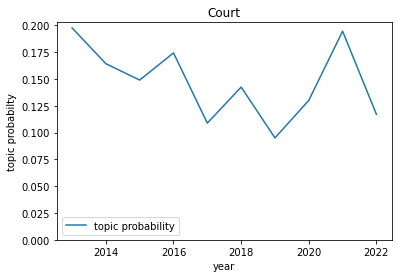

In [38]:
ax = get_prob_topic_per_year(0).plot(x='year',y='topic probability',title='Court')
ax.set_ylim(ymin=0)
ax.set_ylabel('topic probabilty')

Text(0, 0.5, 'topic probabilty')

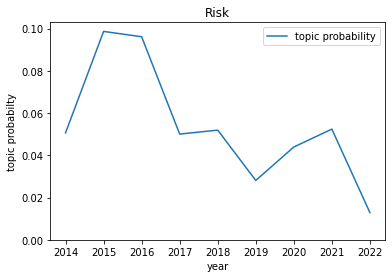

In [44]:
ax = get_prob_topic_per_year(1).plot(x='year',y='topic probability',title='Risk')
ax.set_ylim(ymin=0)
ax.set_ylabel('topic probabilty')

Text(0, 0.5, 'topic probabilty')

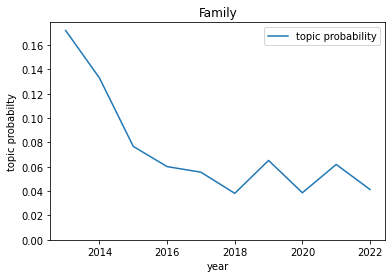

In [40]:
ax = get_prob_topic_per_year(2).plot(x='year',y='topic probability',title='Family')
ax.set_ylim(ymin=0)
ax.set_ylabel('topic probabilty')



Text(0, 0.5, 'topic probabilty')

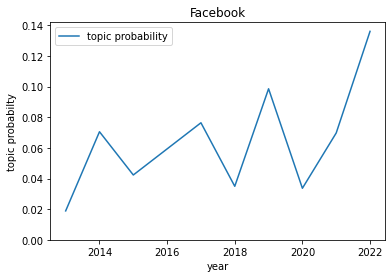

In [41]:
ax = get_prob_topic_per_year(3).plot(x='year',y='topic probability',title='Facebook')
ax.set_ylim(ymin=0)
ax.set_ylabel('topic probabilty')

Text(0, 0.5, 'topic probabilty')

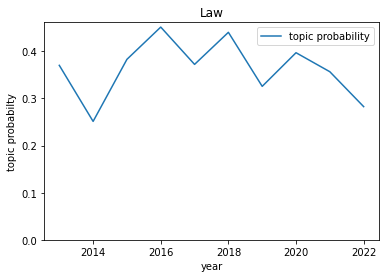

In [43]:
ax = get_prob_topic_per_year(4).plot(x='year',y='topic probability',title='Law')
ax.set_ylim(ymin=0)
ax.set_ylabel('topic probabilty')

Text(0, 0.5, 'topic probabilty')

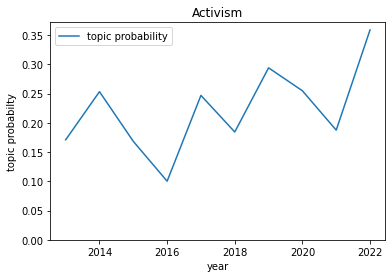

In [42]:
ax = get_prob_topic_per_year(5).plot(x='year',y='topic probability',title='Activism')
ax.set_ylim(ymin=0)
ax.set_ylabel('topic probabilty')

Text(0, 0.5, 'topic probabilty')

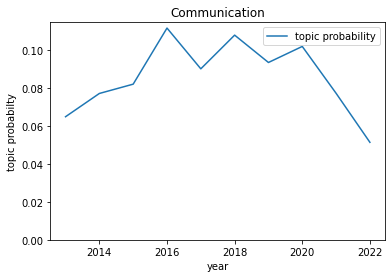

In [37]:
ax = get_prob_topic_per_year(6).plot(x='year',y='topic probability',title='Communication')
ax.set_ylim(ymin=0)
ax.set_ylabel('topic probabilty')